In [29]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
'''
The OpenIFS coupling preparation tool (ocp-tool) prepares input files for a
coupled OpenIFS-FESOM2 or OpenIFS-NEMO climate simulation


To this end it performs three tasks:
1) Modifing the OpenIFS input files to fit the land sea mask and soil types
    to the ocean models land sea mask
2) Generating appropriate OASIS3-MCT input files to fit the modified land
    sea mask
3) Modifing the runoff-mapper drainage basin and arrival point file to fit
    the modified land sea mask


To function, the script therefore needs the following input files:
1) Grid information txt file for the full Gaussian grid of the chosen
    trucation number. This fileset comes with the tool.
2) Grid information txt file for the reduced Gaussian grid This fileset comes
    with the tool.
3) OpenIFS gridpoint input file (ICMGG${EXP_NAME}INIT) containing default
    land-sea mask that will be modified. can be requested from ECMWF:
    openifs-support@ecmwf.int
4) Runoff-mapper input files (runoff_maps.nc) file containing default
    drainage basin and arrival point fields. This fileset is part of the
    EC-Earth input files and available from:


If you have trouble getting this tool to work in your python environment
you may try loading the environment.yaml with:
    conda env create -f environment.yml


@author: Jan Streffing (jan.streffing@awi.de), August 2019
'''

from __future__ import division

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import gribapi
import csv
import math

from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from shutil import copy2

#-----------------------------------------------------------------------------
# Setup
#-----------------------------------------------------------------------------

# Setting constants
earth_radius = 6371. * 1e3 #[m]
longline = ' \n ==================================================  \n'


#-----------------------------------------------------------------------------
# Function definitions
#-----------------------------------------------------------------------------

def read_grid_file(res_num, input_path_reduced_grid, input_path_full_grid, truncation_type, exp_name_oifs='hagw', input_path_oifs='input/openifs_input_default/',verbose=False):
    '''
    This function reads the reduced gaussian gridfile and returns it as a raw
    field
    '''
    if truncation_type == 'linear':
        # linear truncation (T = NN * 2 - 1)
        NN = res_num/2 + 0.5
        grid_txt = '%s/n%d_reduced.txt' % (input_path_reduced_grid, NN)
        
    elif truncation_type == 'cubic-octahedral':
        # cubic octahedral truncation (T = NN - 1)
        NN = res_num + 1
        grid_txt = '%s/o%d_reduced.txt' % (input_path_reduced_grid, NN)

    #print(' Read grid from file: %s ' % (grid_txt,) )

    print(longline)
    print(' Reading OpenIFS gridfile for T%d ' % (res_num))
    print(longline)
    
    if os.path.isfile(grid_txt):
       fin = open(grid_txt, 'r')
       print(' Read grid from file: %s ' % (grid_txt,) )
    else:
       icmfile = '%s/ICMGG%sINIT' % (input_path_oifs, exp_name_oifs) 
       grid_txt = read_grid_from_icmgg(icmfile, NN, truncation_type)
       fin = open(grid_txt, 'r')
       print(' Read grid from file: %s ' % (icmfile,) )

       
    lines = fin.readlines()
    return (lines, NN)


def read_grid_from_icmgg(icmfile, NN, truncation_type):
   """
   Read lon, lats from grib template file
   Uses CDO to get grid description from a GRIB file
   """
   
   latitudes = []
   nlongitudes = []
   
   file=icmfile
   
   # write grid description to file
   # only need to do this once
   os.system('cdo griddes %s > griddes.txt' % (file,))
   
   # read data from text file
   f = open('griddes.txt','r')
   lines = f.readlines()   
   for i in range(0,len(lines)):      
      if 'yvals' in lines[i]:
         yline = i
      elif 'rowlon' in lines[i] or 'reducedPoints' in lines[i]:
         rline = i
   
   # read from yvals until we hit rowlon   
   for i in range(yline,len(lines)):
      line = lines[i]
      print(line)
      if 'rowlon' in line or 'reducedPoints' in line:
         break
      if i == yline:
         # convert data to floats
         tmp_lat = [float(lat) for lat in line.split()[2:]]
      else:
         tmp_lat = [float(lat) for lat in line.split()]
      # append data to latitudes list
      for lat in tmp_lat: latitudes.append(lat) 
      
   for i in range(rline,len(lines)):
      line = lines[i]
      if 'scanningMode' in line: 
         break 
      if i == rline:
         # convert to integers
         tmp_nlon = [int(nlon) for nlon in line.split()[2:]]
      else:
         tmp_nlon = [int(nlon) for nlon in line.split()]
      # append data to nlongitudes list
      for nlon in tmp_nlon: nlongitudes.append(nlon) 
         
   f.close()
   
   print('nlon: ',nlongitudes)
   print('lat: ',latitudes)
   
   # Now construct the grid
   lons = []
   lats = []
   for ilat in range(0,len(nlongitudes)):
      
      lat  = latitudes[ilat]
      nlon = nlongitudes[ilat]
      
      lon1  = np.arange(0,360,360./nlon)
      
      for lon in lon1: 
         lons.append(lon)
         lats.append(lat)   
   
   if truncation_type == 'cubic-octahedral':
      ngrid = 'o%d' % (NN,)
      rfile = 'input/gaussian_grids_octahedral_reduced/%s_reduced.txt' % (ngrid,)
      
   elif truncation_type == 'linear':
      ngrid = 'n%d' % (NN,)
      rfile = 'input/gaussian_grids_linear_reduced/%s_reduced.txt' % (ngrid,)
   
   # Write to text file that CDO can use for interpolations
   f = open(rfile,'w')
   f.write('latitude reduced regular latitude \n')
   f.write('number points points \n')
   f.write(' ------- ------- ------- ---------- \n' )
   
   for ilat in range(0,len(nlongitudes)):
      f.write('%d %d %d %f \n' % (ilat+1, nlongitudes[ilat], len(nlongitudes)*2, latitudes[ilat]))
   f.close()
   
   return rfile


def extract_grid_data(lines,verbose=False):
    '''
    This function takes the raw reduced gaussian coordinate list and returns
    coordinate and neighbour distrance lists for latitude and
    longitude of every grindpoint, as well as the number of latitudes and
    longitudes
    '''
    gridsize = 0
    lons_list       = []  # longitudes of each gridpoint
    lats_list       = []  # latitudes of each gridpoint
    numlons_list    = []  # number of longitude points for each latitude
    dlon_list       = []  # longitude distance in degree at each latitude
    lat_list        = []  # list of latitudes

    for line in lines[3:]:
        # read latitude number, number of longitudes for red. Gaussian and regular Gauss grids
        # convert from strings to floats
        if verbose:
            print(line)
        _, red_points, _, lat = (float(z) for z in line.split())

        # longitudes for reduced Gaussian grid
        dlon = float(360)/red_points
        #The -0.000000001 deals with rounding errors a la 360./644*360=359.9999999999994
        lons = np.arange(0, 360-0.000000001, dlon)
        numlons_list.append(int(red_points))
        dlon_list.append(dlon)
        lat_list.append(lat)

        # set longitudes/latitudes for reduced Gaussian grid on this latitude
        lons_list.extend(lons)
        lats_list.extend([lat]*len(lons))
        gridsize += len(lons)

    return (lons_list, lats_list, numlons_list, dlon_list, lat_list)


def calculate_corner_latlon(lats_list, lons_list, numlons_list, dlon_list,
                            lat_list,verbose=False):
    '''
    This function calculates the latitude and longitude values at the corners
    of the gridcells based on the center values. It also saves both the corner
    and center coordinates into a float32 arrays with oasis3-mct compatible
    structure
    '''

    # OASIS requires grids to be 2D, but IFS grid is 1D, so we give it an
    # extra dimension.
    center_lons = np.array(lons_list, dtype='float32')[np.newaxis, :]
    center_lats = np.array(lats_list, dtype='float32')[np.newaxis, :]
    nx = center_lons.shape[1]
    ny = 1

    print(' Size of grid: nx = %d, ny = %d' % (nx, ny))

    # Now we calculate longitudes/latitudes of corner points for each grid cell
    crn_lons = np.zeros((4, ny, nx))
    crn_lats = np.zeros((4, ny, nx))

    kk = 0 # cell index
    for ii, ni in enumerate(numlons_list):
        '''
        Layout of the four corners

        2 ---------- 1
        |            |
        |            |
        |            |
        3 -----------4

        ^ y
        |
        |
        |
        ----> x
        '''

        dlon = dlon_list[ii]
        lat  = lat_list[ii]
        lons = np.arange(0, 360, dlon)

        #     NP --- j=1 ---|--- j=2 ---|--- j=3 ---|--- j=n --- SP
        #                           <-dlat_n-> <-dlat_s->

        # if first latitude, the previous point was north pole
        if ii == 0:
            dlat_n = 90 - lat
            dlat_s = (lat - lat_list[ii+1]) / 2.

        # if last latitude, the next point is south pole
        elif ii == len(numlons_list)-1:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = lat + 90

        else:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = (lat - lat_list[ii+1]) / 2.

        for jj in range(ni):
            # corner 1: north-east
            crn_lons[0, 0, kk] = lons[jj] + dlon/2.
            crn_lats[0, 0, kk] = lat + dlat_n

            # corner 2: north-west
            crn_lons[1, 0, kk] = lons[jj] - dlon/2.
            crn_lats[1, 0, kk] = lat + dlat_n

            # corner 3: south-west
            crn_lons[2, 0, kk] = lons[jj] - dlon/2.
            crn_lats[2, 0, kk] = lat - dlat_s

            # corner 4: south-east
            crn_lons[3, 0, kk] = lons[jj] + dlon/2.
            crn_lats[3, 0, kk] = lat - dlat_s

            kk += 1

    # Make sure that longitudes are [-180, 180] and not [0, 360]
    center_lons = np.where( center_lons > 180, center_lons - 360, center_lons )
    crn_lons    = np.where( crn_lons > 180, crn_lons - 360, crn_lons )
    return (center_lats, center_lons, crn_lats, crn_lons)


def calculate_area(center_lons, numlons_list, dlon_list, lat_list,verbose=False):
    '''
    This function calculates the area of the gridcells based on the center
    values and saves them into a float32 array with oasis3-mct compatible
    structure
    '''

    # OASIS requires grids to be 2D, but IFS grid is 1D, so we give it an
    # extra dimension.
    nx = center_lons.shape[1]
    ny = 1

     # Now we calculate the cell area of each cell
    gridcell_area = np.zeros((ny, nx))

    kk = 0 # cell index
    for ii, ni in enumerate(numlons_list):

        dlon = dlon_list[ii]
        lat  = lat_list[ii]
        lons = np.arange(0, 360, dlon)

        #     NP --- j=1 ---|--- j=2 ---|--- j=3 ---|--- j=n --- SP
        #                           <-dlat_n-> <-dlat_s->

        # if first latitude, the previous point was north pole
        if ii == 0:
            dlat_n = 90 - lat
            dlat_s = (lat - lat_list[ii+1]) / 2.

        # if last latitude, the next point is south pole
        elif ii == len(numlons_list)-1:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = lat + 90

        else:
            dlat_n = (lat_list[ii-1] - lat) / 2.
            dlat_s = (lat - lat_list[ii+1]) / 2.

        # Grid cell areas in m2 width in latitude of cell is dlat_n + dlat_s
        dx = dlon * np.pi/180. * earth_radius * np.cos( np.pi/180. * lat )
        dy = (dlat_n + dlat_s) * np.pi/180. * earth_radius
        area = dx * dy

        for jj in range(ni):
            gridcell_area[0, kk] = area
            kk += 1

    return(gridcell_area)


def read_oce_grid(input_path_oce, grid_name_oce, interp_res = 'r3600x1801', verbose=False):
    
    print(longline)
    print(' Using cdo and nco to interpolate from ocean to OpenIFS land sea mask')
    
    # Switch to work folder
    current_dir=os.getcwd()
    os.chdir(current_dir+'/input/fesom_mesh/')

    # execute the command
    cmd = './prep_fesom.sh '+grid_name_oce+' '+interp_res+' ../openifs_input_default/ICMGG'+exp_name_oifs+'INIT'
    os.system(cmd)
    os.chdir(current_dir)
    
    print(' Reading ocean based land sea mask:', grid_name_oce)
    mesh=Dataset(input_path_oce+'/'+grid_name_oce+'_oifs.nc',verbose=False)

    # Print some info about oasis files
    if verbose:
        print(mesh.variables.keys())
    
    
    fesom_lsm = mesh.variables['cell_area']
    fesom_grid_sorted = fesom_lsm[:]
    
    print(longline)
    
    return fesom_grid_sorted


def read_lsm(res_num, input_path_oifs, output_path_oifs, exp_name_oifs, num_fields,verbose=False):
    '''
    This function reads the oifs input file in grib format and save it into a
    list of numpy arrays.
    '''
    print(' Opening Grib input file: %s ' % (input_path_oifs,))
    input_file_oifs = input_path_oifs + 'ICMGG' + exp_name_oifs + 'INIT'
    gid = [None] * num_fields
    gribfield = [None] * num_fields
    with open(input_file_oifs, 'rb') as f:
        keys = ['N', 'shortName']

        for i in range(num_fields):
            gid[i] = gribapi.grib_new_from_file(f)
            if gid[i] is None:
                break

            for key in keys:
                if not gribapi.grib_is_defined(gid[i], key):
                    raise ValueError("Key '%s' was not defined" % key)
                if verbose:
                    print('%s=%s' % (key, gribapi.grib_get(gid[i], key)))

            shortName = gribapi.grib_get(gid[i], 'shortName')

            if shortName == 'lsm':
                lsm_id = i
            if shortName == 'slt':
                slt_id = i
            if shortName == 'cl':
                cl_id = i

            nres = gribapi.grib_get(gid[i], 'N')
            gribfield[i] = gribapi.grib_get_values(gid[i])

    return (gribfield, lsm_id, slt_id, cl_id, gid)





def write_lsm(gribfield_mod, input_path_oifs, output_path_oifs, exp_name_oifs,
              grid_name_oce, num_fields, gid,verbose=False):
    '''
    This function copies the input gribfile to the output folder and modifies
    it by writing the whole gribfield_mod, including the altered land sea mask
    and soil type fields into the new file
    '''

    input_file_oifs = input_path_oifs + 'ICMGG' + exp_name_oifs + 'INIT'
    output_file_oifs = output_path_oifs + 'ICMGG' + exp_name_oifs + 'INIT_' + grid_name_oce
    copy2(input_file_oifs, output_file_oifs)

    with open(output_file_oifs, 'r+b') as f:
        for i in range(num_fields):
            gribapi.grib_set_values(gid[i], gribfield_mod[i])
            gribapi.grib_write(gid[i], f)
            gribapi.grib_release(gid[i])


def plotting_lsm(res_num, lsm_binary_l, lsm_binary_a, center_lats, center_lons,verbose=False):
    '''
    This function plots the final land sea mask
    '''

    fig3 = plt.figure(figsize=(24, 14))
    ax3  = fig3.add_subplot(111)
    xptsa = center_lons[np.round(lsm_binary_a[:, :])<1]
    yptsa = center_lats[np.round(lsm_binary_a[:, :])<1]
    xptsl = center_lons[np.round(lsm_binary_l[:, :])<1]
    yptsl = center_lats[np.round(lsm_binary_l[:, :])<1]
    ax3.scatter(xptsl, yptsl, s=50/res_num, color='red', marker='.', label='New dry points')
    ax3.scatter(xptsa, yptsa, s=100/res_num, marker='.', label='Wet points')
    ax3.legend(loc="lower right")
    figname = 'output/plots/land_points_T%d.png' % (res_num,)
    fig3.savefig(figname, format='png',dpi=600)


def generate_coord_area(res_num, input_path_reduced_grid, input_path_full_grid, truncation_type, exp_name_oifs="hagw",verbose=False):
    '''
    This function generates coordinate and areas fields based on
    the full and reduced gaussian gridfiles for a given truncation number.
    '''

    lines, NN = read_grid_file(res_num, input_path_reduced_grid, input_path_full_grid, truncation_type, 
                               exp_name_oifs=exp_name_oifs,verbose=verbose)
    lons_list, lats_list, numlons_list, dlon_list, lat_list = extract_grid_data(lines,verbose=verbose)
    center_lats, center_lons, crn_lats, crn_lons = calculate_corner_latlon(lats_list, lons_list, 
                                                                           numlons_list, dlon_list, 
                                                                           lat_list,verbose=verbose)
    gridcell_area = calculate_area(center_lons, numlons_list, dlon_list, lat_list,verbose=verbose)

    return (center_lats, center_lons, crn_lats, crn_lons, gridcell_area, lons_list, NN)


def process_lsm(res_num, input_path_oifs, output_path_oifs,
                                 exp_name_oifs, grid_name_oce, num_fields,
                                 fesom_grid_sorted, lons_list,
                                 center_lats, center_lons,crn_lats, crn_lons, 
                                 gridcell_area,verbose=False):
    '''
    This function first reads, modifies and finally saves the new land
    sea mask. Every step is mirrored for the soil type file as it has to be
    modified in the exact same locations
    '''

    gribfield, lsm_id, slt_id, cl_id, gid = read_lsm(res_num, input_path_oifs, 
                                                     output_path_oifs, 
                                                     exp_name_oifs, num_fields,verbose=verbose)
    lsm_binary_a, lsm_binary_l, lsm_binary_r, gribfield_mod = modify_lsm(gribfield, 
                                                           fesom_grid_sorted, 
                                                           lsm_id, slt_id, cl_id, 
                                                           lons_list, center_lats, 
                                                           center_lons, crn_lats, crn_lons, 
                                                           gridcell_area,
                                                           verbose=verbose)
    write_lsm(gribfield_mod, input_path_oifs, output_path_oifs, exp_name_oifs, 
              grid_name_oce, num_fields, gid,verbose=verbose)
    return (lsm_binary_a,lsm_binary_l,lsm_binary_r,gribfield_mod)


def write_oasis_files(res_num, output_path_oasis, dir_path, grid_name_oce, center_lats, center_lons, 
                      crn_lats, crn_lons, gridcell_area, lsm_binary_a ,lsm_binary_l , lsm_binary_r, 
                      NN, input_path_runoff,verbose=False):
    '''
    This function writes the binary masks, areas and grids files for
    oasis3-mct
    For OpenIFS we set up three different grids:
    All have the same lons, lats and areas
    but different land-sea masks

    atmo: Land = 0, Ocean = 1  (for atm->ocn fluxes)
    atmr: Land = 1, Ocean = 0  (for atm->runoff mapper)

    atmf is the fraction of ocean in each cell, but
    IFS always has 1 or 0, so it is the same as atmo.
    '''

    NN = int(str(NN)[:-1])
    
    for filebase in ['grids', 'areas', 'masks']:
        filename = '%s/%s%s.nc' % (dir_path, output_path_oasis, filebase)
        print('Writing file: %s ' % (filename,))
        nc = Dataset(filename, 'w', clobber=True)

        # For OpenIFS + NEMO + Runoffmapper we need two atmosphere grids:
        # atmo: used for atm->ocn remapping (to find ocean)
        # atmr: used for atm->runoff remapping (to find land)

        for grids_name in ('{}{:03}'.format(s, int(NN)) for s in ('A', 'L', 'R')):

            # OASIS requires certain names for the dimensions etc
            print(' Write lons, lats, corner points for grid: %s ' % (grids_name,), '(T%s)' % (res_num,))
            xname = 'x_%s' % (grids_name,)
            yname = 'y_%s' % (grids_name,)
            lonname = '%s.lon' % (grids_name,)
            latname = '%s.lat' % (grids_name,)
            nc.createDimension(xname, center_lons.shape[1])
            nc.createDimension(yname, 1)
            id_lon = nc.createVariable(lonname, 'float64', (yname, xname))
            id_lat = nc.createVariable(latname, 'float64', (yname, xname))

            # Not required, but makes grid info more readable
            id_lon.units = 'degrees_east'
            id_lon.standard_name = 'Longitude'
            id_lat.units = 'degrees_north'
            id_lat.standard_name = 'Latitude'

         # Write corner points to grids file
            if filebase == 'grids':
                crnname = 'crn_%s' % (grids_name,)
                cloname = '%s.clo' % (grids_name,)
                claname = '%s.cla' % (grids_name,)
                nc.createDimension(crnname, 4)
                id_clo = nc.createVariable(cloname, 'float64', (crnname, yname, xname))
                id_cla = nc.createVariable(claname, 'float64', (crnname, yname, xname))

         # Write land-sea masks to masks file
            elif filebase == 'masks':
                mskname = '%s.msk' % (grids_name,)
                id_msk = nc.createVariable(mskname, 'int32', (yname, xname))
                id_msk.coordinates = '%s.lat %s.lon' % (grids_name,grids_name)
                id_msk.valid_min = 0.
                id_msk.valid_max = 1

         # Write grid cell area to areas file
            elif filebase == 'areas':
                areaname = '%s.srf' % (grids_name,)
                id_area = nc.createVariable(areaname, 'float64', (yname, xname))
                id_area.coordinates = '%s.lat %s.lon' % (grids_name,grids_name)

            id_lon[:, :] = center_lons[:, :]
            id_lat[:, :] = center_lats[:, :]
            id_lon.valid_min = center_lons.min()
            id_lon.valid_max = center_lons.max()
            id_lat.valid_min = center_lats.min()
            id_lat.valid_max = center_lats.max()

            if filebase == 'grids':
                id_clo[:, :, :] = crn_lons[:, :, :]
                id_cla[:, :, :] = crn_lats[:, :, :]
                id_clo.valid_min = crn_lons.min()
                id_clo.valid_max = crn_lons.max()
                id_cla.valid_min = crn_lats.min()
                id_cla.valid_max = crn_lats.max()

            elif filebase == 'masks':
                if grids_name.startswith('A') :
                    id_msk[:, :] = np.round(lsm_binary_a[:, :])  
                elif grids_name.startswith('L'):
                    id_msk[:, :] = np.round(lsm_binary_l[:, :])
                elif grids_name.startswith('R'):
                    if grid_name_oce == 'ORCA05':
                        id_msk[:, :] = np.abs(np.round(lsm_binary_r[:, :] - 1))
                    else:
                        id_msk[:, :] = np.abs(np.round(lsm_binary_a[:, :] - 1))
                else:
                    raise RuntimeError('Unexpected grid name: {}'.format(grids_name))

            elif filebase == 'areas':
                id_area[:, :] = gridcell_area[:, :]
                id_area.valid_min = gridcell_area.min()
                id_area.valid_max = gridcell_area.max()


        # Copying runoff mapper grids and areas into oasis3-mct files

        input_file_rnf = '%srunoff_%s.nc' % (input_path_runoff, filebase)
        rnffile = Dataset(input_file_rnf, 'r')

        nc.setncatts(rnffile.__dict__)
        for name, dimension in rnffile.dimensions.items():
            nc.createDimension(name, len(dimension) if not dimension.isunlimited() else None)

        for name, variable in rnffile.variables.items():
            var_out = nc.createVariable(name, variable.datatype, variable.dimensions)
            var_out.setncatts({k: variable.getncattr(k) for k in variable.ncattrs()})
            var_out[:] = variable[:]

        rnffile.close()
        nc.close()
        print(' Wrote %s ' % (filename,))

        print(longline)


def modify_runoff_map(res_num, input_path_runoff, output_path_runoff,
                      grid_name_oce, manual_basin_removal,verbose=False):
    '''
    This function generates coordinate and areas fields based on
    the full and reduced gaussian gridfiles for a given truncation number.
    '''
    input_file_rnf = '%srunoff_maps.nc' % (input_path_runoff,)
    output_file_rnf = output_path_runoff+'srunoff_maps_'+grid_name_oce+'.nc'
    if os.path.exists(output_file_rnf):
        os.remove(output_file_rnf)
    copy2(input_file_rnf, output_file_rnf)

    rnffile = Dataset(output_file_rnf, 'r+')
    print (rnffile.variables.keys())

    drainage = rnffile.variables[u'drainage_basin_id'][:]
    arrival = rnffile.variables[u'arrival_point_id'][:]

    # Set projection
    lons = rnffile.variables[u'lon'][:]
    lats = rnffile.variables[u'lat'][:]

    for basin in manual_basin_removal:

        if basin == 'caspian-sea':
            for lo, lon in enumerate(lons):
                if lon > 46 and lon < 56:
                    for la, lat in enumerate(lats):
                        if lat > 36 and lat < 47:
                            if drainage[la, lo] == -2:
                                drainage[la, lo] = 18
                                arrival[la, lo] = -1
                # adding artifical arrival points in the amazon discharge area
                # to close the global water budget
                if lon > 313 and lon < 314.5:
                    for la, lat in enumerate(lats):
                        if lat > 1 and lat < 2:
                            if arrival[la, lo] != -1:
                                arrival[la, lo] = 18

        if basin == 'black-sea':
            for lo, lon in enumerate(lons):
                #removing old basin
                if lon > 27 and lon < 43:
                    for la, lat in enumerate(lats):
                        if lat > 40.5 and lat < 48:
                            if drainage[la, lo] == -2:
                                drainage[la, lo] = 23
                                arrival[la, lo] = -1
                # adding new arrival points
                if lon > 25 and lon < 26.5:
                    for la, lat in enumerate(lats):
                        if lat > 38.5 and lat < 41:
                            if arrival[la, lo] != -1:
                                arrival[la, lo] = 23
                if lon > 23.5 and lon < 25:
                    for la, lat in enumerate(lats):
                        if lat > 38.5 and lat < 41:
                            if arrival[la, lo] != -1:
                                arrival[la, lo] = 28

    # Fix for Ob arrival
    for lo, lon in enumerate(lons):
        #removing old arrival points
        if lon > 60 and lon < 70:
            for la, lat in enumerate(lats):
                if lat > 60 and lat < 80:
                    if arrival[la, lo] == 13:
                        arrival[la, lo] = 6
        # adding new arrival points
        if lon > 72 and lon < 75:
            for la, lat in enumerate(lats):
                if lat > 65 and lat < 75:
                    if arrival[la, lo] == 6:
                        arrival[la, lo] = 13

    # Fix for Glacial calving maps
    # Antarctica
    for lo, lon in enumerate(lons):
        #removing old arrival points
        for la, lat in enumerate(lats):
            if lat < -55:
                if arrival[la, lo] == 66:
                    arrival[la, lo] = -2

    for lo, lon in enumerate(lons):
        # adding new arrival points
        if lon > 300 and lon < 320:
            for la, lat in enumerate(lats):
                if lat > -70 and lat < -60:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 66
        if lon > 320 and lon < 360:
            for la, lat in enumerate(lats):
                if lat > -60 and lat < -50:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 66
        if lon > 170 and lon < 180:
            for la, lat in enumerate(lats):
                if lat > -75 and lat < -65:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 66
    # Greenland
    for lo, lon in enumerate(lons):
        # adding new arrival points
        if lon > 300 and lon < 310:
            for la, lat in enumerate(lats):
                if lat > 50 and lat < 60:
                    if arrival[la, lo] == -2:
                        arrival[la, lo] = 1

    # Saving results
    rnffile.variables[u'drainage_basin_id'][:] = drainage
    rnffile.variables[u'arrival_point_id'][:] = arrival
    rnffile.close()

    plotting_runoff(drainage, arrival, lons, lats)

    return (lons, lats)


def plotting_runoff(drainage, arrival, lons, lats,verbose=False):

    # Split data and concatenate in reverse order to turn by 180° to Prime meridian
    ds1, ds2 = np.hsplit(np.squeeze(drainage), 2)
    drainage_cat = np.concatenate((ds2, ds1), axis=1)
    ds1, ds2 = np.hsplit(np.squeeze(arrival), 2)
    arrival_cat = np.concatenate((ds2, ds1), axis=1)

    lons = lons-180
    lon_0 = lons.mean()
    lat_0 = lats.mean()

    m = Basemap(llcrnrlon=-60., llcrnrlat=-10, urcrnrlon=-30., urcrnrlat=20., \
            resolution='l', area_thresh=1000., projection='cyl')

    #Use meshgrid to create 2D arrays from coordinates
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)

    fig1 = plt.figure(figsize=(12, 8))
    cmap = plt.cm.flag
    cs = m.pcolor(xi, yi, arrival_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))

    lon_0 = lons.mean()
    lat_0 = lats.mean()
    '''
    m = Basemap(llcrnrlon=20., llcrnrlat=30, urcrnrlon=80., urcrnrlat=50., \
            resolution='l', area_thresh=1000., projection='poly', \
            lat_0=0., lon_0=20.)
    #Use meshgrid to create 2D arrays from coordinates
    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, drainage_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_caspian_drainage.png'
    fig1.savefig(figname, format='png')
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, arrival_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_caspian_arrival.png'
    fig1.savefig(figname, format='png')
    '''

    m = Basemap(llcrnrlon=50., llcrnrlat=40, urcrnrlon=110., urcrnrlat=80., \
            resolution='l', area_thresh=1000., projection='cyl')
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, drainage_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_ob_drainage.png'
    fig1.savefig(figname, format='png')
    fig1 = plt.figure(figsize=(12, 8))
    cs = m.pcolor(xi, yi, arrival_cat, cmap=cmap)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 120., 45.))
    m.drawmeridians(np.arange(0., 360., 90.))
    figname = 'output/plots/runoff_ob_arrival.png'
    fig1.savefig(figname, format='png')


def modify_runoff_lsm(res_num, grid_name_oce, manual_basin_removal, lons, lats,
                      output_path_oasis,verbose=False):
    '''
    This function generates coordinate and areas fields based on
    the full and reduced gaussian gridfiles for a given truncation number.
    '''

    # Editing runoff mapper lsm in oasis3-mct masks file
    filename = '%smasks.nc' % (output_path_oasis,)
    oasis = Dataset(filename, 'r+')

    RnfA = oasis.variables[u'RnfA.msk'][:]
    RnfO = oasis.variables[u'RnfO.msk'][:]

    for basin in manual_basin_removal:

        if basin == 'caspian-sea':
            for lo, lon in enumerate(lons):
                if lon > 46 and lon < 56:
                    for la, lat in enumerate(lats):
                        if lat > 36 and lat < 47:
                            RnfA[la, lo] = 0
                            RnfO[la, lo] = 1

    # Saving altered runoff mapper lsm
    oasis.variables[u'RnfA.msk'][:] = RnfA
    oasis.variables[u'RnfO.msk'][:] = RnfO
    oasis.close()



    
    
def modify_lsm(gribfield, fesom_grid_sorted, lsm_id, slt_id, cl_id, lons_list, 
               center_lats, center_lons, crn_lats, crn_lons, gridcell_area,
               verbose=False):
    '''
    This function firstly uses the lake mask to remove lakes from the land sea
    mask and secondly, if set, uses a preselected list of basins to manually
    alter the lsm and slt fields further. It returns both the original mask
    as well as the modified one
    '''
    # Mask with only solid land in correct format for oasis3-mct file
    import copy
    lsm_binary_l = copy.deepcopy(gribfield[lsm_id])
    lsm_binary_l = lsm_binary_l[np.newaxis, :]
    lsm_binary_r = lsm_binary_l.copy()

    # Automatic lake removal with lakes mask
    gribfield_mod = gribfield[:]
    lsm_diff = np.subtract(gribfield_mod[lsm_id][:], fesom_grid_sorted)
    
    # Soil class of removed lakes is set to SANDY CLAY LOAM
    for i in np.arange (0, len(gribfield_mod[slt_id])-1):
        if gribfield_mod[lsm_id][i] <= 0.5 and fesom_grid_sorted[i] >= 0.5:
            gribfield_mod[slt_id][i] = 6
            gribfield_mod[lsm_id][i] = 1 
            
    for i in np.arange (0, len(gribfield_mod[slt_id])-1):
        if gribfield_mod[lsm_id][i] >= 0.5 and fesom_grid_sorted[i] <= 0.5:
            gribfield_mod[slt_id][i] = 0
            gribfield_mod[lsm_id][i] = 0
            
    gribfield_mod[lsm_id]=fesom_grid_sorted
    

    
    # Mask with lakes counting as land in correct format for oasis3-mct file
    lsm_binary_a = gribfield_mod[lsm_id]
    lsm_binary_a = lsm_binary_a[np.newaxis, :]

    return (lsm_binary_a,lsm_binary_l, lsm_binary_r, gribfield_mod)

 

 Reading OpenIFS gridfile for T1279 
 

 Read grid from file: input/gaussian_grids_octahedral_reduced//o1280_reduced.txt 
 Size of grid: nx = 6599680, ny = 1
 

 Using cdo and nco to interpolate from ocean to OpenIFS land sea mask
cdo(1) selname: Process started
cdo(2) setgrid: Process started
cdo    gencon: YAC first order conservative weights from unstructured (3160340) to lonlat (3600x1801) grid
cdo(2) setgrid: Processed 53551354 values from 7 variables over 1 timestep.
cdo(1) selname: Processed 3160340 values from 7 variables over 1 timestep.
cdo    gencon: Processed 3160340 values from 1 variable over 1 timestep [121.40s 3746MB].
cdo(1) selname: Process started
cdo(2) setgrid: Process started
cdo(2) setgrid: Processed 53551354 values from 7 variables over 1 timestep.
cdo(1) selname: Processed 3160340 values from 7 variables over 1 timestep.
cdo    remap: Processed 3160340 values from 1 variable over 1 timestep [3.38s 3104MB].
cdo    setmisstoc: Processed 6483600 values from 1 v

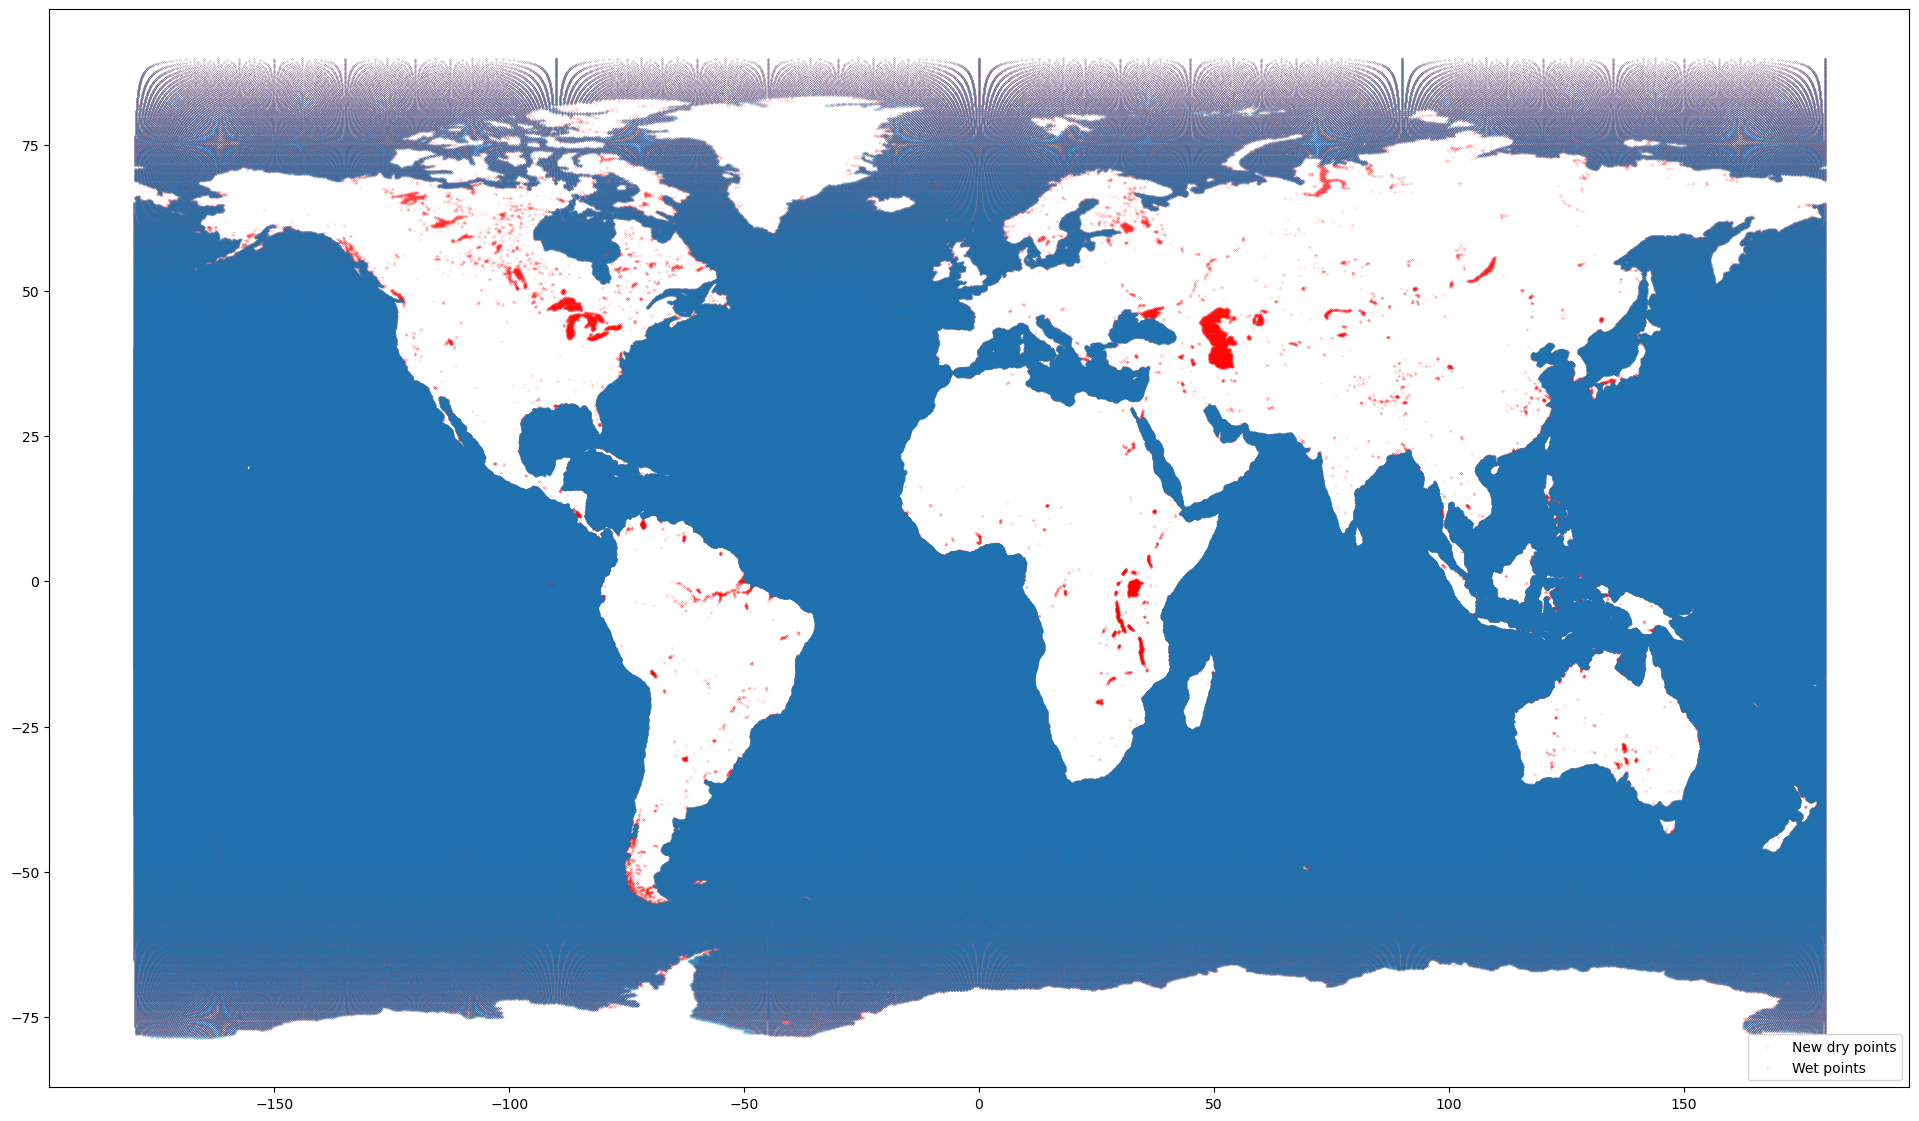

In [30]:
#-----------------------------------------------------------------------------
# Main Program
#-----------------------------------------------------------------------------

if __name__ == '__main__':
    '''
    Main program in which the tool configuration and function calls are located
    Please configure as needed.
    '''
    verbose=False
    
    # Truncation number of desired OpenIFS grid. Multiple possible.
    # Choose the ones you need [63, 95, 159, 255, 319, 399, 511, 799, 1279]
    resolution_list = [1279]

    # Choose type of trucation. linear or cubic-octahedral
    truncation_type = 'cubic-octahedral'

    # OpenIFS experiment name. This 4 digit code is part of the name of the
    # ICMGG????INIT file you got from EMCWF
    exp_name_oifs = 'hf05'#default for cubic-octahedral
    # I have not yet found a way to determine automatically the number of
    # fields in the ICMGG????INIT file. Set it correctly or stuff will break!
    num_fields = 50

    # Name of ocean model grid. 
    grid_name_oce = 'dart'
    # set regular grid for intermediate interpolation. 
    # should be heigher than source grid res.
    interp_res = 'r3600x1801'
    input_path_oce = 'input/fesom_mesh/'
    
    input_path_full_grid = 'input/gaussian_grids_full/'
    input_path_oifs = 'input/openifs_input_default/'
    input_path_runoff = 'input/runoff_map_default/'

    # Output file directories.
    output_path_oifs = 'output/openifs_input_modified/'
    output_path_runoff = 'output/runoff_map_modified/'
    output_path_oasis = 'output/oasis_mct3_input/'
    
    
    
    
    
    # Find working directory
    dir_path = os.getcwd()

        # Input file directories. Place files in appropriate subfolders or modify
    if truncation_type == 'cubic-octahedral':
        input_path_reduced_grid = 'input/gaussian_grids_octahedral_reduced/'
    elif truncation_type == 'linear':
        input_path_reduced_grid = 'input/gaussian_grids_linear_reduced/'
    else:
        sys.exit('truncation type not recognized')


    # Loop over atmosphere resolutions. Todo: select correct exp_name_oifs
    for res_num in resolution_list:

        center_lats, center_lons, \
        crn_lats, crn_lons, \
        gridcell_area, lons_list, \
        NN = generate_coord_area(res_num,
                                 input_path_reduced_grid, input_path_full_grid,
                                 truncation_type,exp_name_oifs=exp_name_oifs,verbose=verbose)

        fesom_grid_sorted = read_oce_grid(input_path_oce ,grid_name_oce ,interp_res ,verbose=verbose)
        
        lsm_binary_a,lsm_binary_l,lsm_binary_r, gribfield_mod = process_lsm(res_num, input_path_oifs, output_path_oifs,
                                 exp_name_oifs, grid_name_oce, num_fields,
                                 fesom_grid_sorted, lons_list,
                                 center_lats, center_lons, crn_lats, crn_lons, 
                                 gridcell_area, verbose=verbose)

        write_oasis_files(res_num,
                          output_path_oasis, dir_path, grid_name_oce,
                          center_lats, center_lons, crn_lats, crn_lons, gridcell_area,
                          lsm_binary_a, lsm_binary_l, lsm_binary_r, NN, input_path_runoff,verbose=verbose)
        
        plotting_lsm(res_num, lsm_binary_l, lsm_binary_a, center_lats, center_lons,verbose=verbose)

        '''lons, lats = modify_runoff_map(res_num, input_path_runoff, output_path_runoff,
                                       grid_name_oce, manual_basin_removal,verbose=verbose)

        modify_runoff_lsm(res_num, grid_name_oce, manual_basin_removal, lons, lats,
                          output_path_oasis,verbose=verbose)'''



In [13]:
def plotting_lsm_onlyone(res_num, lsm_binary_l, center_lats, center_lons,verbose=False):
    '''
    This function plots the final land sea mask
    '''

    fig3 = plt.figure(figsize=(24, 14))
    ax3  = fig3.add_subplot(111)
    xptsa = center_lons[lsm_binary_l[:, :]<1]
    yptsa = center_lats[lsm_binary_l[:, :]<1]

    ax3.scatter(xptsa, yptsa, s=100/res_num, marker='.', label='Wet points')
    ax3.legend(loc="lower right")
    figname = 'output/plots/land_points_T%d.png' % (res_num,)
    fig3.savefig(figname, format='png',dpi=600)

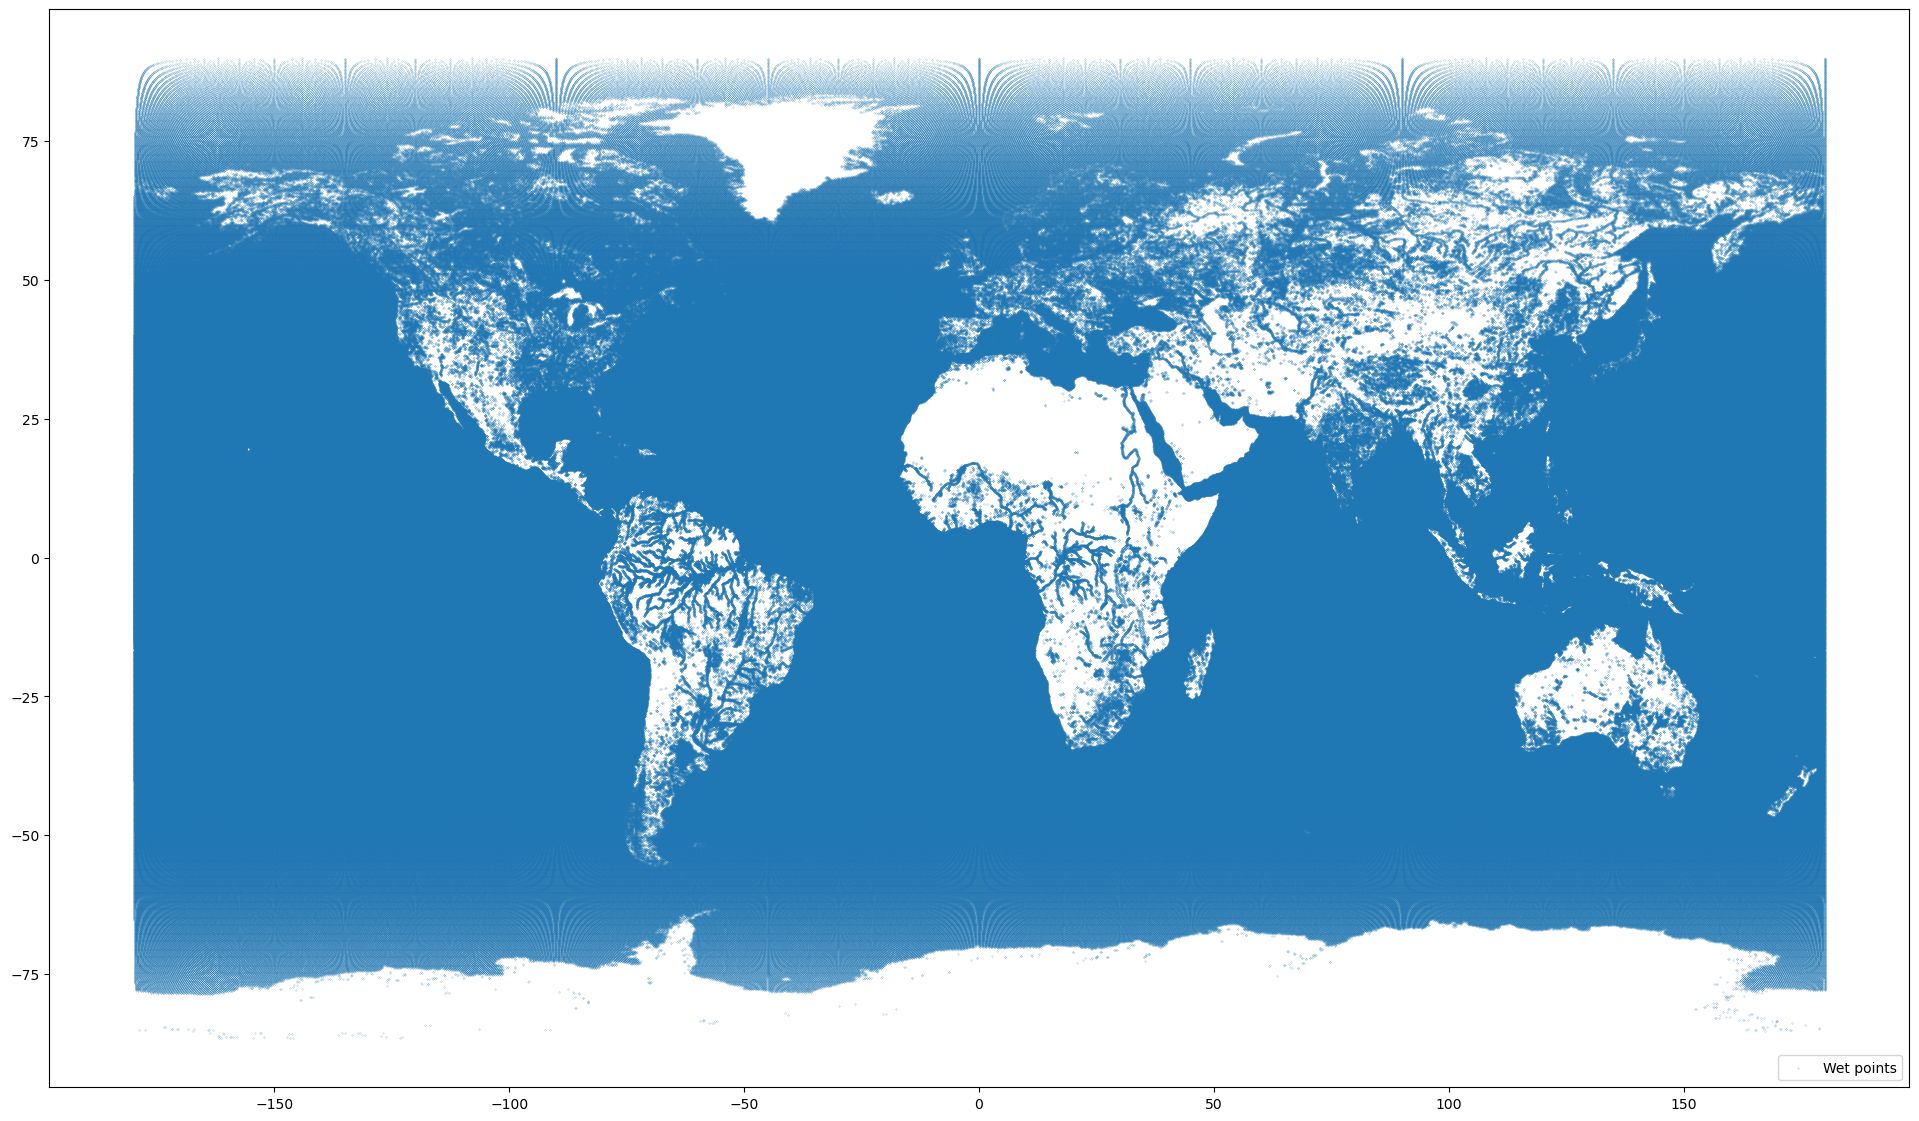

In [27]:
plotting_lsm_onlyone(res_num, lsm_binary_a, center_lats, center_lons,verbose=verbose)


In [24]:
        write_oasis_files(res_num,
                          output_path_oasis, dir_path, grid_name_oce,
                          center_lats, center_lons, crn_lats, crn_lons, gridcell_area,
                          lsm_binary_a, lsm_binary_l, lsm_binary_r, NN, input_path_runoff,verbose=verbose)

Writing file: /work/ab0246/a270092/software/ocp-tool2/output/oasis_mct3_input/grids.nc 
 Write lons, lats, corner points for grid: A128  (T1279)
 Write lons, lats, corner points for grid: L128  (T1279)
 Write lons, lats, corner points for grid: R128  (T1279)
 Wrote /work/ab0246/a270092/software/ocp-tool2/output/oasis_mct3_input/grids.nc 
 

Writing file: /work/ab0246/a270092/software/ocp-tool2/output/oasis_mct3_input/areas.nc 
 Write lons, lats, corner points for grid: A128  (T1279)
 Write lons, lats, corner points for grid: L128  (T1279)
 Write lons, lats, corner points for grid: R128  (T1279)
 Wrote /work/ab0246/a270092/software/ocp-tool2/output/oasis_mct3_input/areas.nc 
 

Writing file: /work/ab0246/a270092/software/ocp-tool2/output/oasis_mct3_input/masks.nc 
 Write lons, lats, corner points for grid: A128  (T1279)
 Write lons, lats, corner points for grid: L128  (T1279)
 Write lons, lats, corner points for grid: R128  (T1279)
 Wrote /work/ab0246/a270092/software/ocp-tool2/output/o